In [1]:
import numpy as np
import pandas as pd
import glob

from os.path import expanduser
home = expanduser("~")

import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
path = home + '/vvm/servers/*'

cpu_usage = [pd.read_csv(f) for f in glob.glob(path + '/jvm.process.cpu.seconds.csv')]
mem_usage = [pd.read_csv(f) for f in glob.glob(path + '/memory.heap.usage.csv')]
thread_count = [pd.read_csv(f) for f in glob.glob(path + '/threads.count.csv')]

for i in range(len(cpu_usage)):
    cpu_usage[i]['t'] -= cpu_usage[i]['t'][0]
    cpu_usage[i]['value'] *= 100
    
    mem_usage[i]['t'] -= mem_usage[i]['t'][0]
    mem_usage[i]['value'] *= 100
    
    thread_count[i]['t'] -= thread_count[i]['t'][0]

In [3]:
def resizeToSmall(A, B):
    A_s, B_s = A.shape[0], B.shape[0]
    
    if (A_s < B_s):
        B = B[:A_s]
    else:
        A = A[:B_s]
        
    return A, B

def averaged_df(df_list, column_index):
    x = np.array(df_list[0][column_index][0:-1])
    for i in range(1, len(df_list)):
        n = np.array(df_list[i][column_index])
        x, n = resizeToSmall(x, n)
        x += n
    return x / len(df_list)

def polyfit(y):
    p15 = np.poly1d(np.polyfit(np.arange(len(y)), y, 15))
    xp = np.linspace(0, len(y) - 1, 1000)
    y_smooth = p15(xp)
    y_smooth = np.where(y_smooth > 0, y_smooth, 0)
    return xp, y_smooth

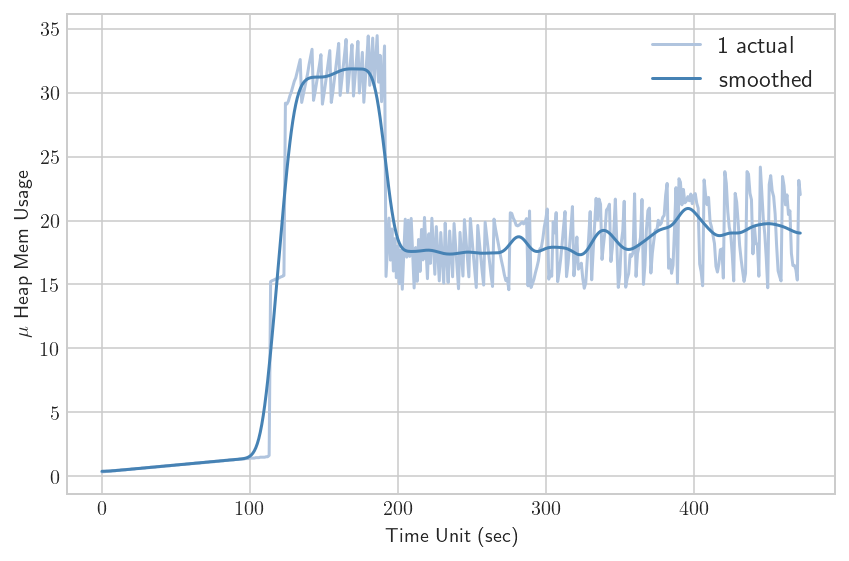

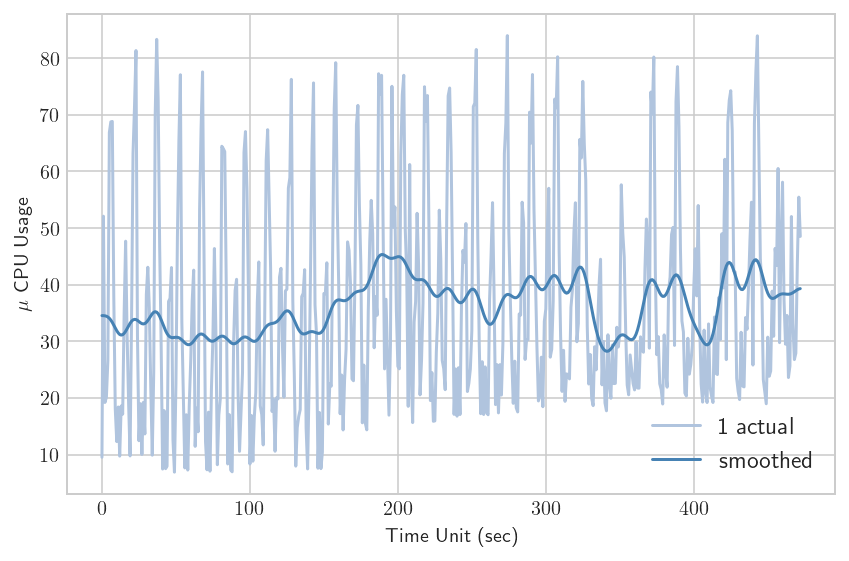

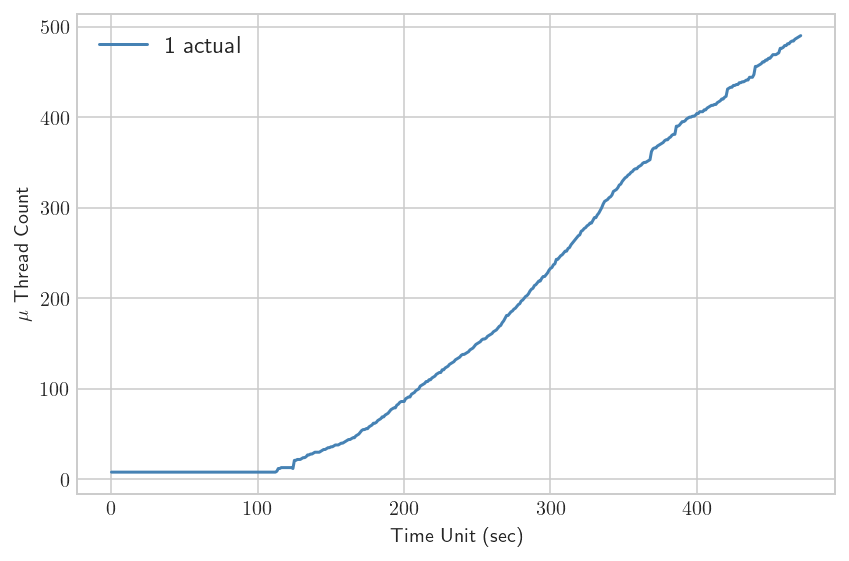

In [4]:
# Mem Usage

plt.figure(figsize=(6, 4))
y_averaged_mem = averaged_df(mem_usage, 'value')
plt.plot(y_averaged_mem, label=f'{len(mem_usage)} actual', color='lightsteelblue')
plt.plot(gaussian_filter1d(y_averaged_mem, sigma=6), label='smoothed', color='steelblue')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ Heap Mem Usage')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-mem-usage.pdf', bbox_inches='tight')
plt.show();

# CPU Usage

plt.figure(figsize=(6, 4))
y_averaged_cpu = averaged_df(cpu_usage, 'value')
plt.plot(y_averaged_cpu, label=f'{len(cpu_usage)} actual', color='lightsteelblue')
plt.plot(gaussian_filter1d(y_averaged_cpu, sigma=6), label='smoothed', color='steelblue')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ CPU Usage')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-cpu-usage.pdf', bbox_inches='tight')
plt.show();

# Thread Count

plt.figure(figsize=(6, 4))
y_averaged_threads = averaged_df(thread_count, 'value')
plt.plot(y_averaged_threads, label=f'{len(thread_count)} actual', color='steelblue')

plt.xlabel('Time Unit (sec)')
plt.ylabel('$\mu$ Thread Count')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-thread-count.pdf', bbox_inches='tight')
plt.show();

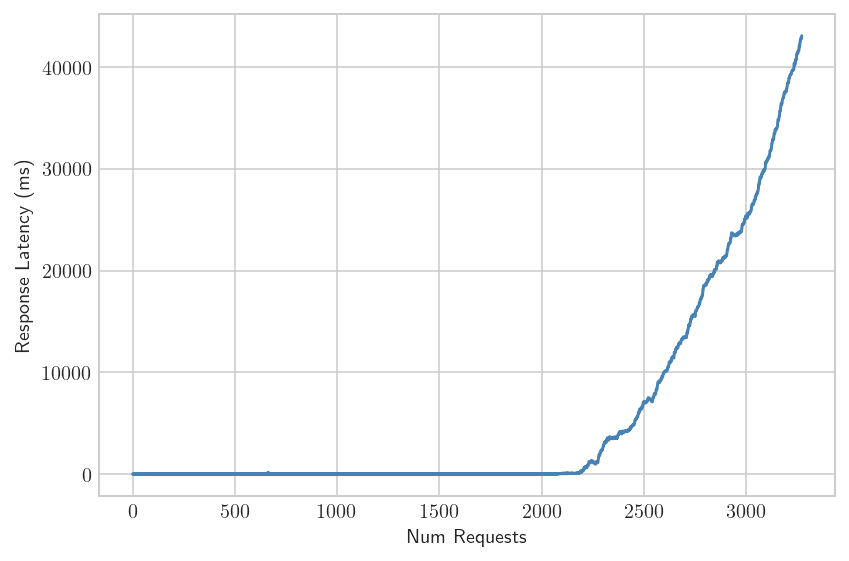

In [5]:
path = home + '/vvm/clients/tallahassee:42039/'

tallahassee = pd.read_csv(path + 'client-metrics.csv').sort_values(by=['initial_timestamp'])
tallahassee['initial_timestamp'] -= tallahassee['initial_timestamp'][0]
tallahassee['initial_timestamp'] /= 1000

# Request Latency Over Time

plt.figure(figsize=(6, 4))
plt.plot(tallahassee['duration'], color='steelblue')

plt.xlabel('Num Requests')
plt.ylabel('Response Latency (ms)')
plt.grid(True); plt.tight_layout(); 
plt.savefig('../media/client-tallahassee-42039-request-latency.pdf', bbox_inches='tight')
plt.show();

(472,) (472,)


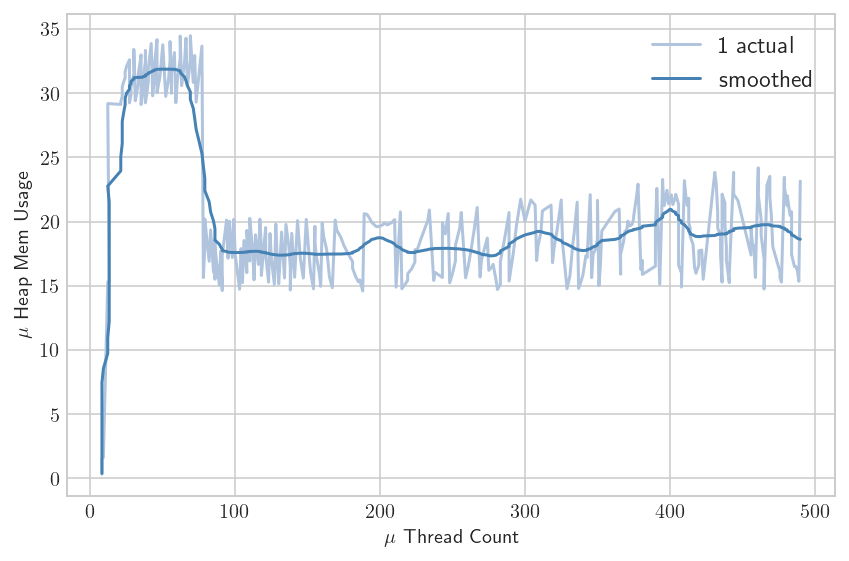

In [6]:
# Mem Usage

plt.figure(figsize=(6, 4))

y_averaged_mem, y_averaged_threads = resizeToSmall(averaged_df(mem_usage, 'value'), 
                                                   averaged_df(thread_count, 'value'))
print(y_averaged_mem.shape, y_averaged_threads.shape)

plt.plot(y_averaged_threads, y_averaged_mem, label=f'{len(mem_usage)} actual', color='lightsteelblue')
plt.plot(y_averaged_threads, gaussian_filter1d(y_averaged_mem, sigma=6), label='smoothed', color='steelblue')

plt.xlabel('$\mu$ Thread Count')
plt.ylabel('$\mu$ Heap Mem Usage')
plt.grid(True); plt.tight_layout(); 
plt.legend(loc='best', fontsize='large')
plt.savefig('../media/server-mem-thread-corr.pdf', bbox_inches='tight')
plt.show();
